<h2>Ejercicio computer vision</h2>

<h3>Librerías</h3>

In [186]:
!python -m pip install numpy
!python -m pip install matplotlib
!python -m pip install opencv-python
!python -m pip install m2bk
!python -m pip install seaborn

In [187]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
from m2bk import *

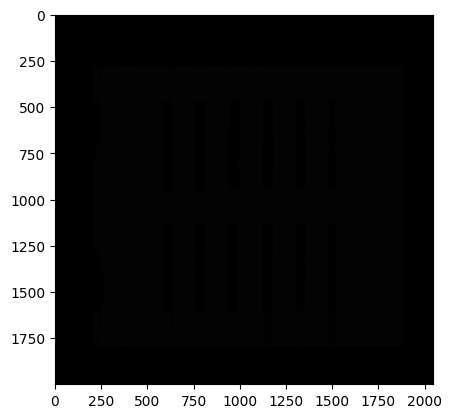

In [275]:
img = cv2.imread('camera_top/ORLB1_Cam4_T_B4840A_A2KV.tif', -1)

plt.imshow(img, cmap='gray', vmin=0, vmax=2**16)

In [276]:
print(img.shape)

(2000, 2048)


<h3> 1. Generar una imagen normalizada de la imagen TIFF (cv2.normalize()), esto producirá 
una imagen con mayor contraste que la original. </h3>

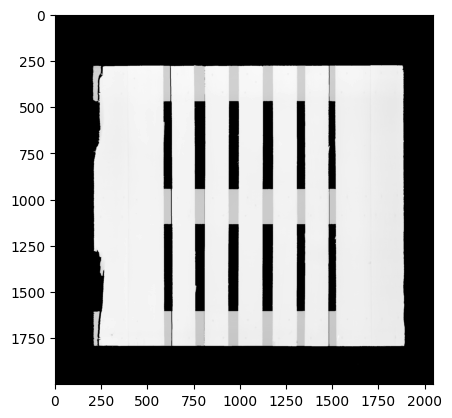

In [277]:
normalizedImage =cv2.normalize(img, None, alpha=0, beta=2**16, norm_type=cv2.NORM_MINMAX)

plt.imshow(normalizedImage, cmap='gray', vmin=0, vmax=2**16)

<h3> 2. Generar dos imágenes binarias a partir de la imagen normalizada, donde en una nos 
quedemos con los tableros verticales y en la otra con los horizontales. </h3>

(array([[2000.,    0.,    0., ...,    0.,    0.,    0.],
        [2000.,    0.,    0., ...,    0.,    0.,    0.],
        [2000.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [2000.,    0.,    0., ...,    0.,    0.,    0.],
        [2000.,    0.,    0., ...,    0.,    0.,    0.],
        [2000.,    0.,    0., ...,    0.,    0.,    0.]]),
 array([    0. ,  6553.5, 13107. , 19660.5, 26214. , 32767.5, 39321. ,
        45874.5, 52428. , 58981.5, 65535. ]),
 <a list of 2048 BarContainer objects>)

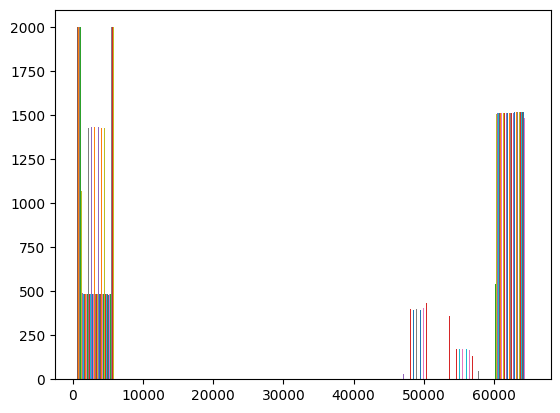

In [278]:
def binarize(image, threshold):
    #Empieza el codigo aqui
    width = image.shape[0]
    height = image.shape[1]
    binary_image = np.zeros((width,height))
    binary_image_2 = np.zeros((width,height))

    for x in range(width):    
        for y in range(height):
                if image[x,y] < threshold:
                    binary_image[x,y] = image[x,y]
                elif image[x,y] > threshold:
                    binary_image_2[x,y] = image[x,y]

    #Termina el codigo aqui
    return binary_image, binary_image_2

plt.hist(normalizedImage)

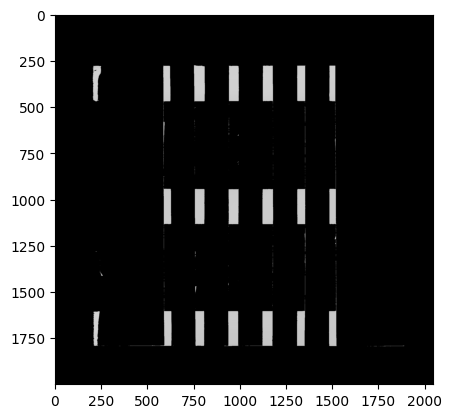

In [279]:
binary_image, binary_image_2 = binarize(normalizedImage, 55000)
plt.imshow(binary_image,cmap='gray', vmin=0, vmax=2**16)

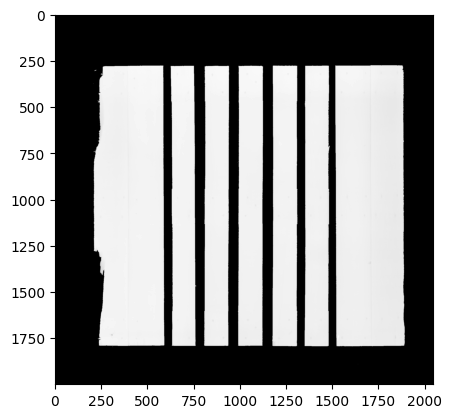

In [280]:
plt.imshow(binary_image_2,cmap='gray', vmin=0, vmax=2**16) 

<h3>3. Hallar los contornos de los tableros en ambas imágenes.</h3>

Primero limpiamos las imágenes

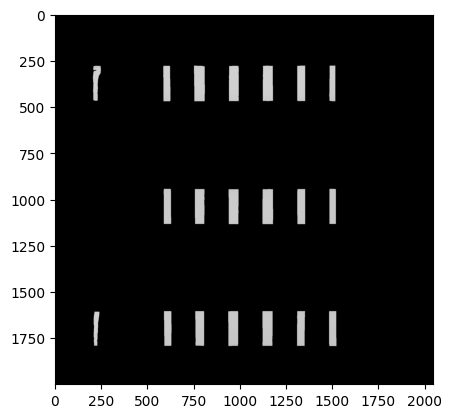

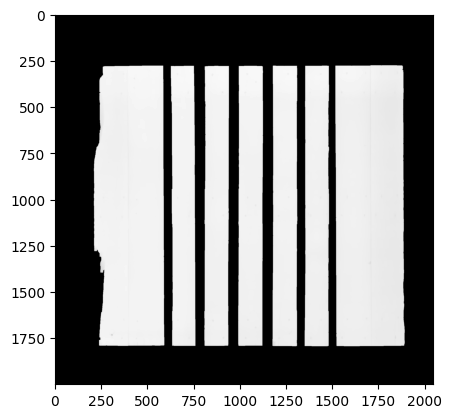

In [281]:
kernel = np.ones((5,5), dtype=np.uint8)

binary_image_clear = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN , kernel,iterations=3)

plt.imshow(binary_image_clear,cmap='gray', vmin=0, vmax=2**16)
plt.show()

binary_image_2_clear = cv2.morphologyEx(binary_image_2, cv2.MORPH_OPEN , kernel,iterations=3)

plt.imshow(binary_image_2_clear,cmap='gray', vmin=0, vmax=2**16)

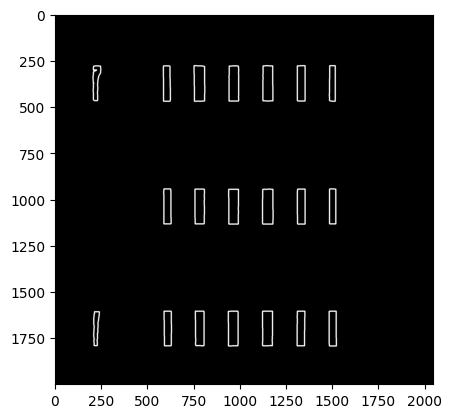

In [282]:
binary_image_clear_n = binary_image_clear.astype(np.uint8)
contours, hierarchy = cv2.findContours(binary_image_clear_n, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
black_image = np.ones((binary_image_clear.shape[0], binary_image_clear.shape[1],1))
img_contours = cv2.drawContours(black_image, contours, -1, 3, 5)

plt.imshow(img_contours, cmap='gray')

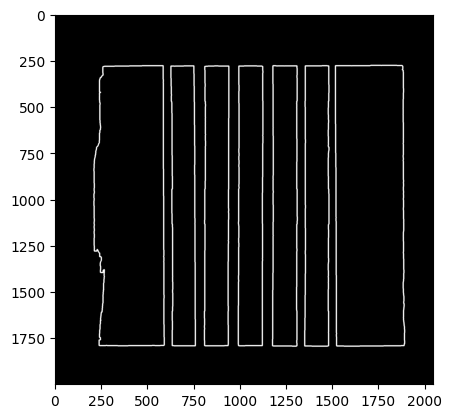

In [283]:
binary_image_clear_n2 = binary_image_2_clear.astype(np.uint8)
contours2, hierarchy2 = cv2.findContours(binary_image_clear_n2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
black_image = np.ones((binary_image_clear.shape[0], binary_image_clear.shape[1],1))
img_contours2 = cv2.drawContours(black_image, contours2, -1, 3, 5)

plt.imshow(img_contours2, cmap='gray')

<h3> 4. Contar el número de tableros. </h3>

<h4> Tablones verticales </h4>

<h8> Calculo del threshold para la detección de tablones dobles </h8>

In [284]:
#VERTICALES
boards_width = []

for cnt in contours2:
    x, y, w, h = cv2.boundingRect(cnt)
    boards_width.append(w)

media = np.mean(boards_width)
b_std = np.std(boards_width)

#El umbral de momento es la media + 0.5 * la desviación tipica 
threshold = media + (0.5 * b_std)
print(f'El umbral para la detección de tablones verticales es {threshold}')

El umbral para la detección de tablones verticales es 258.54272049030226


<h8> Número de tablones verticales </h8>

El número de tablones verticales es: 9


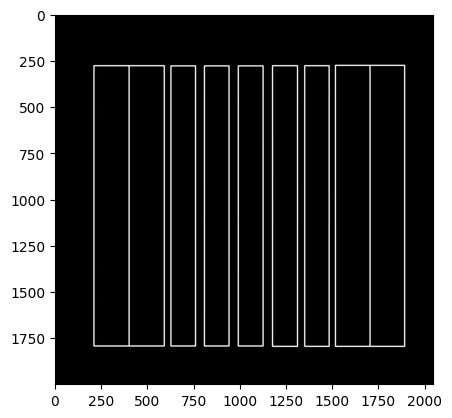

In [285]:
boards_v = []
n_board_image_v = img_contours2.copy()

for cnt in contours2:
    x, y, w, h = cv2.boundingRect(cnt)

    if w > threshold:  # Si es más del threshold
        boards_v.append([x, y, w // 2, h])  # Dividir en dos
        boards_v.append([x + w // 2, y, w // 2, h])
    else:
        boards_v.append([x, y, w, h])

n_vboards = len(boards_v)

for board in boards_v:
    x, y, w, h = board
    cv2.rectangle(n_board_image_v, (x, y), (x + w, y + h), (255, 0, 0), 5)

plt.imshow(n_board_image_v, cmap='gray') 

print(f'El número de tablones verticales es: {n_vboards}')

<h4> Tablones horizontales </h4>

El número de tablones horizontales es: 3


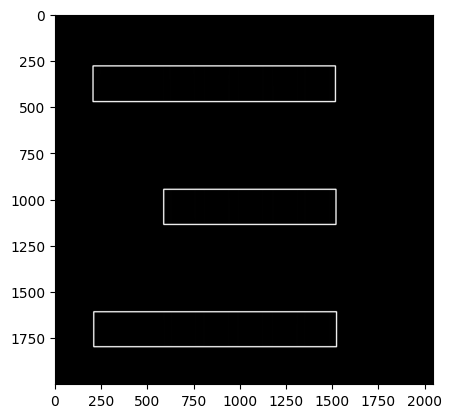

In [286]:
## HORIZONTALES
n_board_image_h = img_contours.copy()

boards_h = []
    
threshold_h = 150

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    
    merged_board = False
    for board in boards_h:
        bx, by, bw, bh = board
        if abs(by - y) <= threshold_h:     
            xToLeft = min(bx, x)  # Chequeamos si la ampliación del rectángulo es más a la izq
            xToRight = max(bx + bw, x + w)  # Same pero para la derecha
            board[0] = xToLeft  # Actualizamos la posición del tablón (en caso de que sea la misma no pasa nada)
            board[2] = xToRight - xToLeft  # Actualizamos el ancho total del tablon
            board[3] = max(bh, h)  # Ajustar la altura
            merged_board = True
            break
    if not merged_board:
        boards_h.append([x, y, w, h])       

for board in boards_h:
    x, y, w, h = board
    cv2.rectangle(n_board_image_h, (x, y), (x + w, y + h), (255, 0, 0), 5)

plt.imshow(n_board_image_h, cmap='gray')    
n_hboards = len(boards_h)

print(f'El número de tablones horizontales es: {n_hboards}')

<h3> 5. Poner un numero a los tableros siguiendo la nomenclatura de la imagen 
anterior. </h3>

<h4> Tablones verticales </h4>

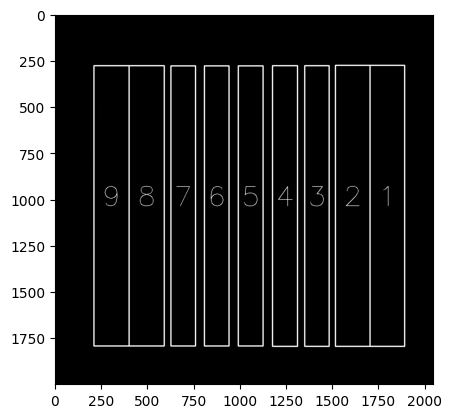

In [287]:
number_bv = n_board_image_v.copy()

#Ordenamos en función de la X del mayor al menor
sorted_boards_v = sorted(boards_v, key=lambda x: x[0], reverse=True)

for i in range(len(sorted_boards_v)):
    x, y, w, h = sorted_boards_v[i]
    cv2.rectangle(number_bv, (x, y), (x + w, y + h), (255, 0, 0), 5)
    
    # Calcula el centro del rectángulo
    center_x = x + w // 2
    center_y = y + h // 2
    
    # Poner el número en el centro del rectángulo
    cv2.putText(number_bv, str(i+1), (center_x-50, center_y), 
                cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 255, 0), 2)


plt.imshow(number_bv, cmap='gray') 

<h4> Tablones horizontales </h4>

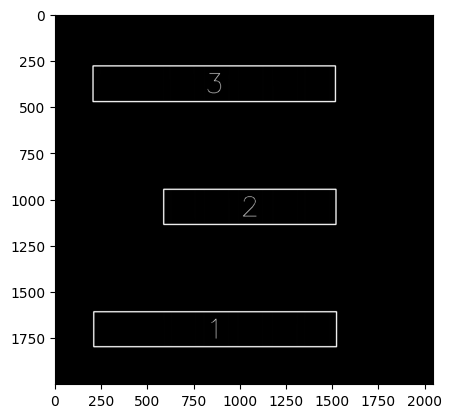

In [288]:
number_bh = n_board_image_h.copy()
#Ordenamos en función de la Y del mayor al menor
sorted_boards_h = sorted(boards_h, key=lambda x: x[1], reverse=True)

for i in range(len(boards_h)):
    x, y, w, h = boards_h[i]
    cv2.rectangle(number_bh, (x, y), (x + w, y + h), (255, 0, 0), 5)

    center_x = x + w // 2
    center_y = y + h // 2

    # Poner el número en el centro del rectángulo
    cv2.putText(number_bh, str(i+1), (center_x-50, center_y+50), 
                cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 255, 0), 2)

plt.imshow(number_bh, cmap='gray')    
n_hboards = len(boards_h)